In [1]:
import pandas as pd
import pyarrow
from dotenv import load_dotenv
import os
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

le = LabelEncoder()

load_dotenv()

file_path = os.getenv('FILE_PATH')
print(file_path)

b:/Matrixian/


In [2]:
df_sample = pd.read_parquet(file_path + "detailed_woning_type_sample.parquet")
df = pd.read_csv(file_path + "bag_image_summary.csv", dtype="string")
df_joined = pd.merge(df_sample, df, how="left", right_on="bag_id", left_on="bag_nummeraanduidingid")
df_sample_with_urls = df_joined[df_joined["frontview_exists"].notna()]
print(os.path.abspath(file_path + "sample_with_urls.csv"))
print(df_sample_with_urls.columns)


b:\Matrixian\sample_with_urls.csv
Index(['bag_nummeraanduidingid', 'source_data_result_id', 'special_house_type',
       'woningtype', 'straatnaam', 'postcode', 'huisnr', 'huisnr_bag_letter',
       'huisnr_bag_toevoeging', 'plaatsnaam', 'opp_pand', 'oppervlakte',
       'build_year', 'build_type', 'is_monument', 'is_protected',
       'source_data_timestamp', 'geometry', 'random_rank', 'bag_id',
       'num_funda_images', 'frontview_exists', 'frontview_funda_url',
       'frontview_google_url', 'frontview_funda_in_business_url'],
      dtype='object')


In [3]:
df_sample_with_urls = df_sample_with_urls.drop(columns=[
    'geometry', 'bag_id', 'source_data_result_id', 'random_rank', 
    'frontview_funda_url', 'frontview_google_url', 'frontview_funda_in_business_url', 
    'special_house_type', 'source_data_timestamp', 'frontview_exists'
])

print(df_sample_with_urls.columns)


Index(['bag_nummeraanduidingid', 'woningtype', 'straatnaam', 'postcode',
       'huisnr', 'huisnr_bag_letter', 'huisnr_bag_toevoeging', 'plaatsnaam',
       'opp_pand', 'oppervlakte', 'build_year', 'build_type', 'is_monument',
       'is_protected', 'num_funda_images'],
      dtype='object')


In [4]:
know_col = ['bag_nummeraanduidingid', 'woningtype']

# getallen 
numerical_cols = ['opp_pand', 'oppervlakte', 'build_year', 'num_funda_images']

# woorden 
categorical_cols = ['straatnaam', 'postcode', 'huisnr_bag_letter', 'huisnr_bag_toevoeging', 'plaatsnaam', 'build_type']

# waarschijnlijk niet nodig
boolean_cols = ['is_monument', 'is_protected']


In [5]:
df_sample_with_urls.to_csv(file_path + "sample_with_urls.csv", index=False)

In [6]:
# New var
# procent_ingenomen
# opp_pand / oppervlakte = procent_ingenomen
df_sample_with_urls['procent_ingenomen'] = df_sample_with_urls['opp_pand'] / df_sample_with_urls['oppervlakte']

numerical_cols = ['opp_pand', 'oppervlakte', 'build_year', 'num_funda_images', 'huisnr']
# opp_pand 0 - inf
# Niks mee gedaan, kan hoog oplopen maar het nadeel van scale tot 0 - 1 is dat je geen grotere panden kan toevoegen en je het verschil tussen 100 en 200 minder groot maakt omdat die allebei zo dicht bij 0 gaan liggen 
# Standard hoe ver van het gemiddelde af
scaler = StandardScaler()
df_sample_with_urls ['opp_pand']= scaler.fit_transform(df_sample_with_urls[['opp_pand']])

# oppervlakte 0 - inf
# Niks mee gedaan, kan hoog oplopen maar het nadeel van scale tot 0 - 1 is dat je geen grotere panden kan toevoegen en je het verschil tussen 100 en 200 minder groot maakt omdat die allebei zo dicht bij 0 gaan liggen 
df_sample_with_urls['oppervlakte'] = scaler.fit_transform(df_sample_with_urls[['oppervlakte']])

# build_year 0 - 2025
df_sample_with_urls ['build_year']= scaler.fit_transform(df_sample_with_urls[['build_year']])

# num_funda_images NaN, 0 - inf
# weg gehaald, want veel of weinig fotos kan niks zeggen over het type huis en al zal dat wel kunnen, willen we het model daar niet op trainen

# huisnr


categorical_cols = ['straatnaam', 'postcode', 'huisnr_bag_letter', 'huisnr_bag_toevoeging', 'plaatsnaam', 'build_type']
# straatnaam naam
# 2d vector naar locatie
# df['straatnaam'] = df['straatnaam'].str.strip().str.lower()


# postcode 4(0-9) + 2(a-z)
# 2d vector naar locatie

# huisnr_bag_letter NaN of a-z

# van 0 tot 1 waar niks = 0, a = 1/27, z = 1
# def letter_score(val):
#     if isinstance(val, str) and val.isalpha():
#         return (ord(val.lower()) - ord('a') + 1) / 26
#     return 0.0
# df_sample_with_urls['huisnr_bag_letter_score'] = df_sample_with_urls['huisnr_bag_letter'].map(letter_score)

df_sample_with_urls['huisnr_bag_letter'] = df_sample_with_urls['huisnr_bag_letter'].notna().astype(int)

# huisnr_bag_toevoeging NaN of x(a-z) of x(0-9) of x(a-z,0-9)
df_sample_with_urls['huisnr_bag_toevoeging'] = df_sample_with_urls['huisnr_bag_toevoeging'].notna().astype(int)

# plaatsnaam naam
# 2d vector naar locatie
# df['plaatsnaam'] = df['plaatsnaam'].str.strip().str.lower()


# build_type 5 types
build_type = df_sample_with_urls[['build_type']]
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_array = encoder.fit_transform(build_type)
raw_feature_names = encoder.get_feature_names_out(['build_type'])
clean_feature_names = [name.replace(' ', '_') for name in raw_feature_names]
encoded_df = pd.DataFrame(encoded_array, columns=clean_feature_names, index=df_sample_with_urls.index)
df_sample_with_urls.drop('build_type', axis=1, inplace=True)
df_sample_with_urls = pd.concat([df_sample_with_urls, encoded_df], axis=1)

boolean_cols = ['is_monument', 'is_protected']
# is_monument NaN, 0 - 1
df_sample_with_urls['is_monument'] = df_sample_with_urls['is_monument'].fillna(0).astype(int)

# is_protected NaN, 0 - 1
df_sample_with_urls['is_protected'] = df_sample_with_urls['is_protected'].fillna(0).astype(int)



In [7]:
df_sample_with_urls = df_sample_with_urls.drop(columns=[
    'num_funda_images', 'straatnaam', 
    'postcode', 'plaatsnaam'
])

df_sample_with_urls.to_csv(file_path + "cleaned_sample_with_urls.csv", index=False)

print(df_sample_with_urls.columns)

Index(['bag_nummeraanduidingid', 'woningtype', 'huisnr', 'huisnr_bag_letter',
       'huisnr_bag_toevoeging', 'opp_pand', 'oppervlakte', 'build_year',
       'is_monument', 'is_protected', 'procent_ingenomen',
       'build_type_Appartement', 'build_type_Hoekwoning',
       'build_type_Tussen_of_geschakelde_woning', 'build_type_Tweeonder1kap',
       'build_type_Verschillend', 'build_type_Vrijstaande_woning'],
      dtype='object')


In [ ]:
features = [
    'huisnr',                                   # 0 - inf
    'huisnr_bag_letter',                        # 0 - 1
    'huisnr_bag_toevoeging',                    # 0 - 1
    'opp_pand',                                 # StandardScaler
    'oppervlakte',                              # StandardScaler
    'build_year',                               # StandardScaler
    'build_type_Appartement',                   # OneHotEncoder
    'build_type_Hoekwoning',                    # OneHotEncoder
    'build_type_Tussen_of_geschakelde_woning',   # OneHotEncoder
    'build_type_Tweeonder1kap',                 # OneHotEncoder
    'build_type_Verschillend',                  # OneHotEncoder
    'is_monument',                              # 0 - 1
    'is_protected',                             # 0 - 1
    'procent_ingenomen'                         # 0 - 1
]

target = 'woningtype'

In [9]:
X = df_sample_with_urls[features]
y = df_sample_with_urls[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


KeyError: "['build_type_Tussen___geschakelde_woning'] not in index"

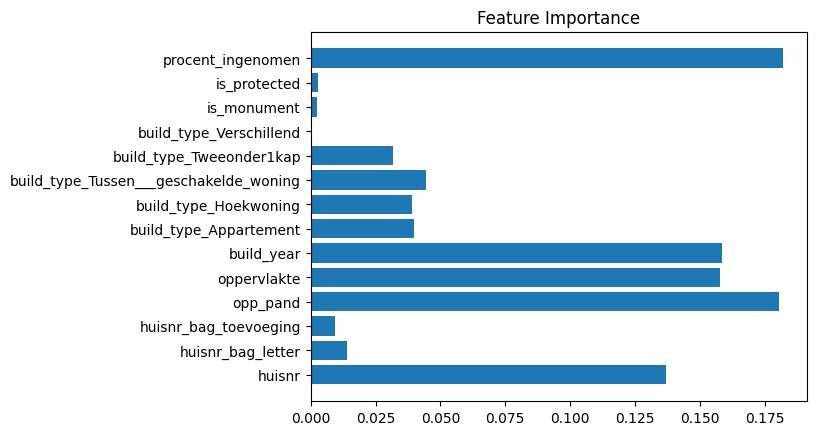

In [ ]:
importances = model.feature_importances_
plt.barh(features, importances)
plt.title("Feature Importance")
plt.show()